# EMDOT Tutorial

This tutorial, based off the "Evaluating Model Performance in Medical Datasets Over Time" paper, explains how users can apply the EMDOT framework to evaluate their own models on their own datasets and prediction tasks of interest.

## Import libraries

To start, we import various components of the emdot package. In order to install the emdot package, do the following:

```
conda create --name <env_name> python==3.8.3
conda activate <env_name>

git clone https://github.com/acmi-lab/EvaluationOverTime.git
cd EvaluationOverTime/src
pip install .
```

To make the above environment available to your jupyter notebook, run:
`python -m ipykernel install --user --name=<env_name>`

In [2]:
from emdot.eot_experiment import EotExperiment
from emdot.example_datasets import get_toy_breast_cancer_data
from emdot.models.LR import LR
from emdot.models.GBDT import GBDT
from emdot.models.MLP import MLP
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from emdot.utils import plot_metric_vs_time

## Quick Start

First, we walk through a simple example of how users can set up an experiment to evaluate model performance over time using the following default options: 
* dataset: toy breast cancer data
* task: binary classification 
* models: logistic regression, gradient boosted decision trees, and feed forward neural networks
* metrics: AUC, AUPRC, F1 score, accuracy
* visualizations: model performance over time (Figure 3 in paper)

Note: while the medical datasets in the paper are easily accessible by researchers after signing data use agreements, unfortunately we cannot re-release the medical data itself in our package.

In later sections, we will describe how users can **customize** each of these defaults to datasets, models, metrics, tasks, and visualizations of their preference.

### 0) Preliminaries

As in any typical machine learning experiment, we must specify: 

0. Experiment parameters (max iterations, number of seeds, etc.)

1. The dataset (assumed to be pre-processed and ready for inference, save for numerical variables which we normalize in the framework using the relevant training set).

2. The model class of in interest and its hyperparameter search space

In [3]:
training_regime = 'sliding_window'
seed_num = 3
seed_list = list(range(seed_num))

model_name = 'LR'

dataset_name = 'toy_data'
label = 'target'
training_regime = 'sliding_window'

# retrieve the (mostly) preprocessed dataset 
#  (note: numerical values do not have to be normalized
#  since the scaling/offsets depend on the training set)
df, col_dict = get_toy_breast_cancer_data()

# select the desired model and hyperparameters
models = {
    "LR": {
        "model_class": LR,
        "search_space": {
            "C": [10.0**e for e in np.arange(-2, 5)],
            "max_iter": [500],
        }
    },
    "GBDT": {
        "model_class": GBDT,
        "search_space": {
            "n_estimators": [50, 100],
            "max_depth": [3, 5],
            "learning_rate": [0.01, 0.1],
        }
    },
    "MLP": {
        "model_class": MLP,
        "search_space": {
            "hidden_layer_sizes": [(3,), (5,)],
            "learning_rate_init": [0.0001, 0.001, 0.01],
            "max_iter": [500],
        }
    }  
}
model_class = models[model_name]['model_class']
hyperparam_grid = models[model_name]['search_space']
hyperparam_grid['max_iter'] = [max_iter]

### 1) Create an EotExperiment object

Here, users can specify:
1. `dataset_name`: (`str`) name of dataset, used for display purposes only.
2. `df`: (`DataFrame`) pre-processed dataframe, which includes all of the columns mentioned in col_dict. All categorical variables should be converted to dummies, however numerical features do not need to be normalized. This is to ensure that the same scaling factors and offsets from the training data are applied to the validation and test sets.
3. `col_dict`: (`dict`) dictionary of the following format:

    {
        "numerical_features": ['numerical_col1', 'numerical_col2', ...],
        "all_features": ['feature_col1', 'feature_col2', ...],
        "label_cols": ['label_col1', 'label_col2', ...],
        "time_col": "Year of diagnosis",
        "ID": "Patient ID"
    }

    Descriptions of each key:value pair are below: 
    * `"numerical_features"`: names of all numerical features
    * `"all_features"`: names of all features in df, including numerical features; make sure to exclude outcomes
    * `"label_cols"`: names of column(s) corresponding to label
    * `"time_col"`: name of column corresponding to timestamp (year, month, etc.)
    * `"ID"`: unique identifier for each patient
4. `label`: (`str`) name of the column in the dataframe to be used as the label (e.g. "mortality", "MORTALITY_180D")
5. `model_class`: (`ExpModel` object) model class to evaluate. Should implement the models.ExpModel interface.
6. `model_name`: (`str`) name of model class (e.g. "LR", "GBDT"), used for display purposes only.
7. `hyperparam_grid`: (`dict`) dictionary containing grid of hyperparameters to search over (e.g. {"C": [0.01, 0.1, 1]})
8. `training_regime`: (`str`) training regime to use in evaluation of performance over time (e.g. "all_historical", "sliding_window", "all_historical_subsampling")
9. `initial_train_window`: (`tuple`) tuple with the first timepoint and last timepoint (inclusive) of the FIRST in-sample time window to be used for training (e.g. (1975, 1978) would be a four-year time range.)
The oldest model is trained on data in this time range, and subsequent models are trained on newer data.
10. `train_end`: (`int` or `float`) the latest timepoint of the entire in-sample time range.
11. `test_end`: (`int` or `float`) the latest timepoint of the entire out-of-sample time range
12. `train_prop`: (`float`) proportion of in-sample data to use as training set.
13. `val_prop`: (`float`) proportion of in-sample data to use as validation set.
14. `test_prop`: (`float`) proportion of in-sample data to use as test set.
15. `window_length`: (`int`) number of timepoints in sliding window. If doing sliding window evaluation: should equal train_end_t - train_start_t + 1. If doing subsampling with all-historical: this is used to compute the number of samples to subsample so that it is comparable to the sliding window evaluation. Thus, set window_length to be the same as used in sliding window evaluation.
16. `time_unit`: (`str`) unit of time that timepoints are in. used for display purposes only.
17. `model_folder`: (`str`) path to folder to save trained models. If None, models will not be saved.

In [4]:
experiment = EotExperiment(
    dataset_name = dataset_name,
    df = df, 
    col_dict = col_dict, 
    label = label,
    model_class = model_class,
    model_name = model_name,
    hyperparam_grid = hyperparam_grid,
    training_regime = training_regime,
    initial_train_window = (0, 4),
    train_end = 7,
    test_end = 9,
    train_prop = 0.5,
    val_prop = 0.25,
    test_prop = 0.25,
    window_length = 5,
    time_unit = 'Year',
    model_folder = './model_info')

### 2) Run the EotExperiment

Here we run the EotExperiment specified in the previous cell, and store the results for future analysis.

In [7]:
result_df, model_info = experiment.run_experiment(seed_list, eval_metric="auc")

result_name = f"{dataset_name}_{max_iter}_{label}_{model_name}_{seed_num}_{training_regime}.csv"

result_folder = f'result/{model_name}/{dataset_name}'
if not os.path.exists('result'):
    os.makedirs(result_folder)

result_df.to_csv(f"./{result_folder}/{result_name}")

## store coefficients if available
if model_name == "LR":
    model_info.to_csv(f"./model_info/{model_name}/{dataset_name}/{result_name}")


In [8]:
result_df.head()  # performance

,model,test_type,train_start,train_end,test_start,test_end,auc,auprc,acc,f1,dataset_name,seed,train_size,val_size,test_size,best_hparams,staleness
0,LR,insample,0,4,4,4,1.000000,1.00000,0.923077,0.923077,toy_data,0,147,73,13,"{'C': 1.0, 'max_iter': 500}",0
1,LR,outsample,0,4,5,5,1.000000,1.00000,1.000000,1.000000,toy_data,0,147,73,54,"{'C': 1.0, 'max_iter': 500}",1
2,LR,outsample,0,4,6,6,0.994681,0.99719,0.957746,0.969072,toy_data,0,147,73,71,"{'C': 1.0, 'max_iter': 500}",2
3,LR,outsample,0,4,7,7,1.000000,1.00000,1.000000,1.000000,toy_data,0,147,73,46,"{'C': 1.0, 'max_iter': 500}",3
4,LR,outsample,0,4,8,8,1.000000,1.00000,0.980769,0.985915,toy_data,0,147,73,52,"{'C': 1.0, 'max_iter': 500}",4


In [11]:
model_info.head()  # coefficients

,train_start,train_end,seed,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,timept,Patient ID
0,0,4,0,-0.477710,-0.619939,-0.523558,-0.491086,-0.112749,-0.238017,-0.740021,...,-0.786141,-0.644664,-0.693399,-0.207169,-0.498490,-0.626653,0.114687,-0.612264,-0.413742,-0.228510
1,1,5,0,-0.130873,-0.096093,-0.132560,-0.127244,-0.058571,-0.085663,-0.106896,...,-0.141952,-0.130087,-0.082685,-0.096048,-0.112424,-0.146647,-0.083826,-0.044341,-0.064013,-0.052879
2,2,6,0,-0.133465,-0.103484,-0.132679,-0.129807,-0.033877,-0.055861,-0.106507,...,-0.144884,-0.138044,-0.089452,-0.079793,-0.106686,-0.139225,-0.091559,-0.048277,-0.075165,-0.050188
3,3,7,0,-1.286512,0.376413,-1.196060,-1.217494,-0.646544,1.446898,-1.351668,...,-0.569752,-0.938142,-1.703370,0.367916,-1.211548,-0.698911,-1.490270,-0.868519,-0.291570,-2.076323
4,0,4,1,-0.671068,-0.232479,-0.661185,-0.586179,0.051995,-0.235696,-0.593502,...,-0.851695,-0.686596,-0.562378,-0.359742,-0.413805,-0.764853,-0.332699,-0.404379,-0.492903,-0.042420


### 3) Visualize results

Here we visualize the performance of models trained until each point in time, with test AUCs evaluated on all future points in time.

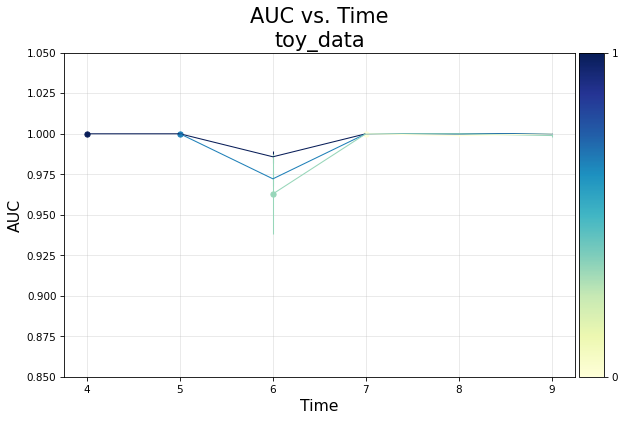

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

figsize = (8, 5.5)
dpi = 75

fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, constrained_layout=True)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plot_metric_vs_time(result_df, "auc", dataset_name, fig, ax, cax=cax, ylim=(0.85, 1.05), 
                    cus_x=[4, 5, 6, 7, 8], xlabel="Time")
plt.show()

# Customization

Here, we describe how users can easily plug in their own datasets, tasks, models, metrics, visualizations, and tasks. To summarize:

1. Custom **datasets and tasks**: in the `EotExperiment` object, simply replace the `dataset_name`, `label`, `df`, `col_dict`, `initial_train_window`, `train_end`, `test_end`, `window_length`, and `time_unit` according to your preferences for the dataset and task of interest.

2. Custom **models**: implement the `ExpModel` abstract class. This just requires you to define `fit()` and `evaluate()` functions for your model.

3. Custom **metrics**: in your `ExpModel`, return the metrics of interest in a dictionary in the `evaluate()` function.

4. Custom **visualizations**: the `run_experiment()` function of the `EotExperiment` class returns: 

    * `result_df`: dataframe containing test performance metrics of each model trained up to each time point, and evaluated on subsequent time points. Additionally includes the test performance evaluated on the latest in-sample time point. 
    * `model_info`: dataframe containing coefficients of every model
    
    These dataframes can then be visualized using standard plotting packages such as `matplotlib`. By default, we include in `emdot.utils` a `plot_metric_vs_time()` function.

If in doubt about the details of some object or class, simply run the `help(...)` function on it.

### 1) Custom Datasets

Suppose you would like to apply EMDOT to your own pre-processed dataset (except for numerical features, for which normalization is handled in the emdot package due to different data splits over time). 

You will have to define the following variables for your dataset (see Quick Start section for descriptions):

In [ ]:
dataset_name = "custom_dataset"

df = pd.DataFrame({
    'patient_id': np.ones(10),
    'feature1': np.ones(10),
    'feature2': np.ones(10),
    'feature3': np.ones(10),
    'timestamp': np.arange(10),
    'label1': np.random.randint(2, size=10),
    'label2': np.random.randint(2, size=10)
})

label = "label1"  # label of interest

col_dict = {
    "processed_numerical_feature": ["feature1"],
    "processed_all_feature": ["feature1", "feature2", "feature3"],
    "processed_label": ["label1", "label2"],
    "year_label": "timestamp",
    "ID": "patient_id"
}

initial_train_window = (0, 4)
train_end = 8
test_end = 9
window_length = 5
time_unit = "year"

Once you have defined these variables, you can use them to help define an EotExperiment object.

In [10]:
experiment = EotExperiment(
    dataset_name=dataset_name,
    df=df, 
    col_dict=col_dict, 
    label=label,
    ...  # TODO: fill in other parameters as appropriate
    initial_train_window=initial_train_window,
    train_end=train_end,
    test_end=test_end,
    ...
    window_length=window_length,
    time_unit=time_unit,
    ...)

### 2, 3) Custom Models & Metrics

Any model evaluated by EMDOT must implement the `ExpModel` abstract class. Metrics should be defined in the `evaluate()` method. One must also choose a unique name for the model class, as well as a grid of hyperparameters to search over.

In [13]:
from emdot import ExpModel

class CustomModel(ExpModel):
    def __init__(self, hyperparam1, hyperparam2):
        super().__init__('CustomModelName')

        self.model = # TODO: model implementation

    def fit(self, X_train, y_train):
        pass  # TODO: training process
    
    def evaluate(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        
        metric1 = evaluation1(y_test, y_pred)  # TODO: evaluation metric implementation
        metric2 = evaluation2(y_test, y_pred)
        metric3 = evaluation3(y_test, y_pred)

        return {
            "metric1_name": metric1,
            "metric2_name": metric2,
            "metric3_name": metric3,
        }
    
    def get_coefs(self, feature_names):
        pass  # TODO: get coefficients of the model if there are any. Otherwise, return None.
    
model_class = CustomModel
model_name = 'CustomModelName'
hyperparam_grid = {
    "hyperparam1": [hyperparam1_v1, hyperparam1_v2],
    "hyperparam2": [hyperparam2_v1, hyperparam2_v2],
}


Once the models and hyperparameter grids are defined, they are used to help define the `EotExperiment` object.

In [ ]:
experiment = EotExperiment(
    ...
    model_class=model_class,
    model_name=model_name,
    hyperparam_grid=hyperparam_grid,
    ...)

### 4) Custom visualization

After running the `EotExperiment`, one can visualize the resulting `result_df` and coefficients stored in `model_info` (if available).

In [14]:
from emdot.utils import plot_metric_vs_time

result_df, model_info = custom_eot_experiment.run_experiemnt()  # see examples of result_df and model_info above.

fig, ax = plt.subplots(1, 1)
plot_metric_vs_time(result_df, metric_name1, dataset_name, fig, ax)